<a href="https://colab.research.google.com/github/vimesh630/Revenue_Forecasting/blob/main/Prophet_for_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Mount Google Drive & Import Required Libraries

In [61]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from prophet import Prophet
from tqdm import tqdm
from datetime import datetime
from dateutil.relativedelta import relativedelta

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. Load Dataset

In [62]:
CSV_PATH = "/content/drive/MyDrive/VERGER/Revenue_Forecasting/forecasting_data.csv"
TARGET_YEAR  = 2027
TARGET_MONTH = 3

# Prophet settings
MIN_POINTS_FOR_PROPHET = 2        # Minimum months of history to fit Prophet well
FREQ = "MS"
ROLLING_PRICE_WINDOW = 2
HIST_ACTIVE_MONTHS = 6

#3. Data Preprocessing

In [63]:
df = pd.read_csv(CSV_PATH)

# Ensure Month_No exists
if "Month_No" in df.columns:
    month_num = df["Month_No"].astype(pd.Int64Dtype()).fillna(1)
else:
    month_map = {m: i for i, m in enumerate(
        ["January","February","March","April","May","June","July","August","September","October","November","December"], start=1)}
    month_num = df["Month"].map(month_map).astype(pd.Int64Dtype()).fillna(1)

df["Year"] = df["Year"].astype(pd.Int64Dtype()).fillna(1)
df["date"] = pd.to_datetime(dict(year=df["Year"], month=month_num, day=1), errors='coerce')
df = df.dropna(subset=["date"])
df = df[["date","Year","Month","Account","Product","Type","Quantity","Unit_Price","Revenue"]].copy()

# Convert numeric columns
df["Quantity"] = pd.to_numeric(df["Quantity"], errors='coerce').clip(lower=0).fillna(0)
df["Unit_Price"] = pd.to_numeric(df["Unit_Price"], errors='coerce').clip(lower=0).fillna(0)
df["Revenue"] = pd.to_numeric(df["Revenue"], errors='coerce').clip(lower=0).fillna(0)

#4. Aggregate to monthly per series(handle multiple orders in same month)

In [64]:
agg = (df.groupby(["Account","Product","Type","date"], as_index=False)
       .agg(Quantity=("Quantity","sum"),
            Revenue=("Revenue","sum"),
            Unit_Price=("Unit_Price",
                        lambda x: (x * df.loc[x.index, "Quantity"]).sum() / df.loc[x.index, "Quantity"].sum()
                        if df.loc[x.index, "Quantity"].sum() > 0 else x.mean())
           ))
agg["Unit_Price"] = agg["Unit_Price"].fillna(0)
agg = agg[["Account","Product","Type","date","Quantity","Unit_Price","Revenue"]]

#5. Build complete monthly timelines (fill missing months with 0 qty)

In [65]:
last_hist_date = agg["date"].max()
active_cutoff = last_hist_date - relativedelta(months=HIST_ACTIVE_MONTHS)
all_series_keys = (agg.groupby(["Account","Product","Type"])
                   .filter(lambda x: (x["Quantity"][x["date"]>active_cutoff].sum() > 0) and len(x) >= MIN_POINTS_FOR_PROPHET)
                   [["Account","Product","Type"]]
                   .drop_duplicates()
                   .reset_index(drop=True))

global_min_date = agg["date"].min()
global_max_date = agg["date"].max()
target_date = pd.Timestamp(year=TARGET_YEAR, month=TARGET_MONTH, day=1)
if target_date <= global_max_date:
    raise ValueError(f"Target {target_date.strftime('%Y-%m')} is not after your last data month {global_max_date.strftime('%Y-%m')}.")

def month_range(start, end, freq="MS"):
    return pd.date_range(start=start, end=end, freq=freq)

calendar = pd.DataFrame({"date": month_range(global_min_date, target_date, FREQ)})

# Product-level median price fallback
product_price_stats = (agg.groupby(["Product"])
                       .agg(product_median_price=("Unit_Price","median"))
                       .reset_index())

#6. Helper Functions

In [66]:
def prepare_series(full_df, account, product, typ):
    sub = full_df[(full_df["Account"]==account) & (full_df["Product"]==product) & (full_df["Type"]==typ)].copy()
    s = calendar.merge(sub, on="date", how="left")
    s["Account"] = account
    s["Product"] = product
    s["Type"] = typ
    for col in ["Quantity","Revenue","Unit_Price"]:
        s[col] = s[col].fillna(0 if col != "Unit_Price" else np.nan)
    s["Unit_Price"] = s["Unit_Price"].ffill().bfill()
    return s

def seasonal_naive_forecast(history_df, forecast_months):
    hist = history_df.set_index("date")["Quantity"].copy()
    preds = []
    for i in range(1, forecast_months+1):
        future_month = history_df["date"].max() + relativedelta(months=i)
        same_month_last_year = future_month - relativedelta(years=1)
        if same_month_last_year in hist.index:
            preds.append(float(hist.loc[same_month_last_year]))
        else:
            last_nonzero = hist[hist > 0].tail(3)
            preds.append(float(last_nonzero.mean()) if len(last_nonzero) > 0 else 0.0)
    return np.array(preds, dtype=float)

def estimate_future_price(series_df, horizon_months, product_level_stats):
    s = series_df.copy()
    s["price_for_roll"] = s["Unit_Price"].where(s["Unit_Price"]>0)
    recent = s.dropna(subset=["price_for_roll"]).tail(ROLLING_PRICE_WINDOW)
    if not recent.empty:
        base_price = float(recent["price_for_roll"].median())
    else:
        prod = s["Product"].iloc[0]
        row = product_level_stats[product_level_stats["Product"]==prod]
        if not row.empty and not np.isnan(row["product_median_price"].iloc[0]):
            base_price = float(row["product_median_price"].iloc[0])
        else:
            last_known = s["Unit_Price"][s["Unit_Price"]>0].tail(1)
            base_price = float(last_known.iloc[0]) if not last_known.empty else 0.0
    return np.full(shape=(horizon_months,), fill_value=base_price, dtype=float)

def prophet_forecast_quantity(series_df, forecast_months):
    hist = series_df[series_df["date"] <= global_max_date].copy()
    df_p = pd.DataFrame({"ds": hist["date"], "y": hist["Quantity"].astype(float)})
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False,
                changepoint_prior_scale=0.5, seasonality_mode="additive")
    m.fit(df_p)
    fut = m.make_future_dataframe(periods=forecast_months, freq="MS")
    fcst = m.predict(fut)
    mask = fcst["ds"] > global_max_date
    yhat = fcst.loc[mask, "yhat"].to_numpy(dtype=float)
    return np.clip(yhat, 0, None)

def clip_forecast(series_df, forecast):
    hist_avg = series_df["Quantity"].mean()
    hist_max = series_df["Quantity"].max()
    # Clip forecast to realistic range: max 1.5x historical max or 3x historical mean
    return np.minimum(forecast, max(hist_max*1.5, hist_avg*3))

# Forecast horizon
delta = relativedelta(target_date, global_max_date)
months_to_forecast = delta.years * 12 + delta.months + 1

#7. Forecasting Loop

In [67]:
results = []
for idx, row in tqdm(all_series_keys.iterrows(), total=len(all_series_keys), desc="Forecasting"):
    acc, prod, typ = row["Account"], row["Product"], row["Type"]
    s = prepare_series(agg, acc, prod, typ)
    s_hist = s[s["date"] <= global_max_date]
    n_points = len(s_hist)

    # Choose model
    use_prophet = n_points >= MIN_POINTS_FOR_PROPHET and s_hist["Quantity"].sum() > 0
    if use_prophet:
        try:
            qty_preds = prophet_forecast_quantity(s, months_to_forecast)
            qty_preds = clip_forecast(s_hist, qty_preds)
        except:
            qty_preds = seasonal_naive_forecast(s_hist, months_to_forecast)
    else:
        qty_preds = seasonal_naive_forecast(s_hist, months_to_forecast)

    # Price prediction
    price_preds = estimate_future_price(s, months_to_forecast, product_price_stats)

    # Build forecast records
    future_months = [(global_max_date + relativedelta(months=i)).replace(day=1)
                     for i in range(1, months_to_forecast+1)]
    for d, q, p in zip(future_months, qty_preds, price_preds):
        results.append({
            "Year": d.year,
            "Month": f"{d.month:02d}",
            "Account": acc,
            "Product": prod,
            "Type": typ,
            "Forecast_Quantity": float(q),
            "Forecast_Revenue": float(q) * float(p)
        })


Forecasting:   0%|          | 0/35 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/528nu6yi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/wzu1ug6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64557', 'data', 'file=/tmp/tmpa3_0xx1n/528nu6yi.json', 'init=/tmp/tmpa3_0xx1n/wzu1ug6h.json', 'output', 'file=/tmp/tmpa3_0xx1n/prophet_model79uuhmhj/prophet_model-20250825035530.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:55:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Forecasting:   3%|▎         | 1/35 [00:00<00:29,  1.15it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/iseg1ylj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/oaxr006c.json
DEBUG

#8. Results & Save

In [68]:
out = pd.DataFrame(results)
out["Forecast_Quantity"] = out["Forecast_Quantity"].round(2)
out["Forecast_Revenue"]  = out["Forecast_Revenue"].round(2)

# ✅ Shuffle output so it’s not alphabetical
out = out.sort_values(by=["Year", "Month"]).reset_index(drop=True)

display(out)  # just to preview

# Save to Drive
OUT_PATH = f"/content/drive/MyDrive/VERGER/Revenue_Forecasting/customer_level_forecast_{target_date.strftime('%Y_%m')}.csv"
out.to_csv(OUT_PATH, index=False)
print(f"Saved: {OUT_PATH}")

,Year,Month,Account,Product,Type,Forecast_Quantity,Forecast_Revenue
0,2025,02,AGFR,Cinnamon Bark Sri Lanka EO,Conventional,8.71,2178.36
1,2025,02,BLFR,Cinnamon Leaf Sri Lanka EO,Conventional,716.88,13262.31
2,2025,02,CNGR,Cinnamon Bark EO Org.,Organic,285.55,58538.15
3,2025,02,CNGR,Cinnamon Bark Sri Lanka EO,Conventional,18.06,3130.66
4,2025,02,CNGR,Pepper Black Sri Lanka EO,Conventional,269.44,8056.16
...,...,...,...,...,...,...,...
940,2027,04,TKGL,Clove Bud Sri Lanka EO,Conventional,50.71,3164.21
941,2027,04,TKGL,Clove Bud Sri Lanka EO FFL,Conventional,81.65,4082.73
942,2027,04,TKGL,Ginger Fresh Sri Lanka EO Org,Organic,0.09,45.90
943,2027,04,VDSP,Cinnamon Leaf Sri Lanka EO,Conventional,786.39,15531.26


Saved: /content/drive/MyDrive/VERGER/Revenue_Forecasting/customer_level_forecast_2027_03.csv


DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/r9hsx1_7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/on3gtzgi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69548', 'data', 'file=/tmp/tmpa3_0xx1n/r9hsx1_7.json', 'init=/tmp/tmpa3_0xx1n/on3gtzgi.json', 'output', 'file=/tmp/tmpa3_0xx1n/prophet_modelvz5zeic4/prophet_model-20250825035729.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:57:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
INFO:prophet:Making 2 forecasts with cutoffs betw

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/eatxv8fv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/1arihega.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24593', 'data', 'file=/tmp/tmpa3_0xx1n/eatxv8fv.json', 'init=/tmp/tmpa3_0xx1n/1arihega.json', 'output', 'file=/tmp/tmpa3_0xx1n/prophet_modelttvcyl00/prophet_model-20250825035729.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:57:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/wwyu94k1.json
DEBUG:cmdstanpy:input tempfi

⚠️ Cross-validation failed for FRGL-Cinnamon Leaf Sri Lanka EO: Less data than horizon after initial window. Make horizon or initial shorter.


03:57:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
INFO:prophet:Making 1 forecasts with cutoffs between 2022-01-02 00:00:00 and 2022-01-02 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/rjq7czn1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/qpes748o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91279', 'data', 'file=/tmp/tmpa3_0xx1n/rjq7czn1.json', 'init=/tmp/tmpa3_0xx1n/qpes748o.json', 'output', 'file=/tmp/tmpa3_0xx1n/prophet_model2f5iw6es/prophet_model-20250825035732.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:57:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/tjm1kmoa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/a1rw8dat.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/cai5a6vn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/leznmi5z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89517', 'data', 'file=/tmp/tmpa3_0xx1n/cai5a6vn.json', 'init=/tmp/tmpa3_0xx1n/leznmi5z.json', 'output', 'file=/tmp/tmpa3_0xx1n/prophet_modelaezd323m/prophet_model-20250825035734.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:57:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/fdl0zcbq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/ggcwdj36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

⚠️ Cross-validation failed for GVGL-Cinnamon Bark Sri Lanka EO: Less data than horizon after initial window. Make horizon or initial shorter.


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/hzebql2y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/39iaix2h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29547', 'data', 'file=/tmp/tmpa3_0xx1n/hzebql2y.json', 'init=/tmp/tmpa3_0xx1n/39iaix2h.json', 'output', 'file=/tmp/tmpa3_0xx1n/prophet_model8wwmg8y6/prophet_model-20250825035736.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:57:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


⚠️ Cross-validation failed for GVGL-Cinnamon Bark Sri Lanka EO Rec : Less data than horizon after initial window. Make horizon or initial shorter.


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
INFO:prophet:n_changepoints greater than number of observations. Using 20.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/eit8gapk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/fmfhkhl9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92817', 'data', 'file=/tmp/tmpa3_0xx1n/eit8gapk.json', 'init=/tmp/tmpa3_0xx1n/fmfhkhl9.json', 'output', 'file=/tmp/tmpa3_0xx1n/prophet_modelmgeu6tud/prophet_model-20250825035736.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:57:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:

⚠️ Cross-validation failed for GVGL-Cinnamon Leaf Sri Lanka EO: Less data than horizon after initial window. Make horizon or initial shorter.
⚠️ Cross-validation failed for IFGL-CINNAMON LEAF OIL: Less data than horizon after initial window. Make horizon or initial shorter.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/88mg64md.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3_0xx1n/i5_kbn30.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16848', 'data', 'file=/tmp/tmpa3_0xx1n/88mg64md.json', 'init=/tmp/tmpa3_0xx1n/i5_kbn30.json', 'output', 'file=/tmp/tmpa3_0xx1n/prophet_model5ju8k9e3/prophet_model-20250825035737.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:57:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
INFO:prophet:n_changepoints greater than number o

⚠️ Cross-validation failed for IFGL-Cinnamon Leaf Sri Lanka EO: Less data than horizon after initial window. Make horizon or initial shorter.


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


⚠️ Cross-validation failed for RBUS-CINNAMON BARK OIL: Less data than horizon after initial window. Make horizon or initial shorter.
✅ Forecasting and accuracy evaluation complete!
            horizon           mse          rmse           mae      mape  \
0  88 days 15:00:00  3.388785e+07   4559.464870   4545.574811  1.647422   
1 104 days 12:00:00  4.198998e+07   5691.341289   5549.753357  1.388024   
2 112 days 08:00:00  1.683593e+08  11905.556949  10955.527826  1.418361   

      mdape     smape  coverage Account            Product          Type  
0  1.611937  0.870560  0.500000    FRGL  CINNAMON LEAF OIL  Conventional  
1  1.388024  0.797228  0.375000    GVGL  CINNAMON BARK OIL  Conventional  
2  1.480507  1.363819  0.222222    GVGL  CINNAMON LEAF OIL  Conventional  


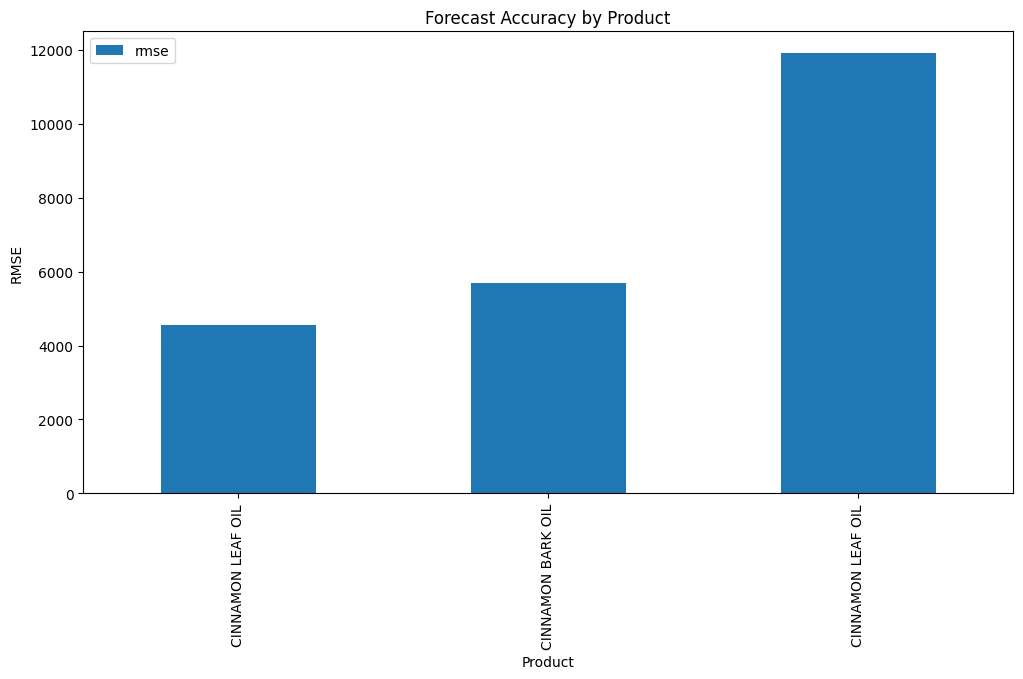

In [69]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import pandas as pd

# === Function to forecast + evaluate each customer-product combo ===
def forecast_and_evaluate(group, horizon="180 days", initial="730 days", period="90 days"):
    # Prepare data for Prophet
    df_prophet = group.rename(columns={"date": "ds", "Revenue": "y"})[["ds", "y"]]

    # Skip if not enough data
    if df_prophet.shape[0] < 24:
        return None, None, None

    # Fit Prophet
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(df_prophet)

    # Forecast future
    future = model.make_future_dataframe(periods=12, freq="M")
    forecast = model.predict(future)

    # Run cross-validation
    try:
        df_cv = cross_validation(model, initial=initial, period=period, horizon=horizon)
        df_p = performance_metrics(df_cv)
    except Exception as e:
        print(f"⚠️ Cross-validation failed for {group['Account'].iloc[0]}-{group['Product'].iloc[0]}: {e}")
        return forecast, None, None

    return forecast, df_cv, df_p


# === Apply to all customer-product-type groups ===
results = []
metrics_list = []

for (account, product, ctype), group in df.groupby(["Account", "Product", "Type"]):
    forecast, df_cv, df_p = forecast_and_evaluate(group)

    if forecast is not None:
        # Save forecasts
        f = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()
        f["Account"], f["Product"], f["Type"] = account, product, ctype
        results.append(f)

        # Save metrics summary
        if df_p is not None:
            avg_metrics = df_p.mean().to_dict()
            avg_metrics.update({"Account": account, "Product": product, "Type": ctype})
            metrics_list.append(avg_metrics)

# Combine forecasts & metrics
all_forecasts = pd.concat(results).reset_index(drop=True)
all_metrics = pd.DataFrame(metrics_list)

# Sort forecasts by time
all_forecasts = all_forecasts.sort_values(by=["Account", "Product", "Type", "ds"]).reset_index(drop=True)

# Save outputs
all_forecasts.to_csv("customer_product_forecasts.csv", index=False)
all_metrics.to_csv("customer_product_metrics.csv", index=False)

print("✅ Forecasting and accuracy evaluation complete!")
print(all_metrics.head())

# Example: plot RMSE across products
if not all_metrics.empty:
    plt.figure(figsize=(12,6))
    all_metrics.sort_values("rmse").plot(x="Product", y="rmse", kind="bar", ax=plt.gca())
    plt.ylabel("RMSE")
    plt.title("Forecast Accuracy by Product")
    plt.show()
